<a href="https://colab.research.google.com/github/daviethedeveloper/TensorFlowNotes/blob/main/Food_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Project

In [1]:
## Check the GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cf11ef55-1e50-9b6c-998c-5134023c16cf)


## Helper Functions

> Use of helper functions for TensorFlow to do small tasks required for notebooks.

> Downloaded(import) a script load from there

> Script is available can be found on github

In [2]:
# Downlaod helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-14 21:19:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-14 21:19:15 (95.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Impor the functions from the downloaded file
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets from TensorFlow

link: https://www.tensorflow.org/datasets/catalog/food101

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all avaiable datasets in TFDS
print("food101" in datasets_list) # Check if food101 ds is in here

True


In [ ]:
# Download it to notebook ( take x time )
# ** Tensor Format **

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned in tuple
                                             with_info=True)

## Exploring the Food101 data from TensorFlow Datasets

* Class_Names
* Shape of input data (image tensors)
* Datatype of the input data
* What the labels look like (one-hot encoding, label encoding)
* Labels match up with class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class name -> dig in the meta data
class_names = ds_info.features["label"].names

# First 10 labels
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [19]:
# Take one sample of the train data
train_one_data = train_data.take(1)
train_one_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [41]:
# Ouput information about the training sample
for image, label in train_one_data:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 31
  Class name (str form): donuts
  


In [42]:
# What does the image tensor look like? From TFDS's Food101
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

In [43]:
# Min and Max values 0-> 255
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

> Will have to preprocess the data
> Different image shape

### Plot and image from TensorFlow Data

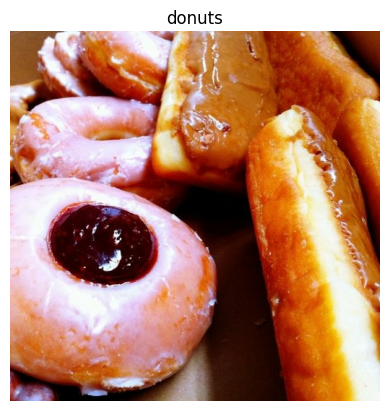

In [44]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title check if correct
plt.axis(False);

## Preprocessing functions for data

>Neural networks perform best when data is in certain way

>Create the preprocessing functions and map it to the data

About the data:
* In  `uint8` datatype
* Comprised of all different size tensors(differnet sized images)
* Not scaled (the pixel values are between 0 &255)

Models:
* Prefer Data in `float32` dtype (MIX: `float16`)
* For batches, TF likes all of the Tensors within a batch to be the same size
* Scaled (values between 0 & 1 ) normalized tensors perform better

With these points need to tackle with preprocessing function

Functions needs to:
1. reshpae the images to the same size
2. Convert the dtype of the image tensors from `unit8` to `float32`

In [45]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [47]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n{image[:2]}...., \nShape: {image.shape},\nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
[[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]]...., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>
Image after preprocessing:
[[[1.34030609e+02 8.90306168e+01 5.80306129e+01]
  [1.36045914e+02 9.10459213e+01 6.00459175e+01]
  [1.37846939e+02 9.28469391e+01 6.38469391e+01]
  ...
  [1.30265366e+02 4.79183846e+01 1.62753057e+00]
  [1.30760223e+02 4.37602272e+01 4.59267795e-02]
  [1.34739838e+02 4.87398338e+01 1.73983324e+00]]

 [[1.41551025e+02 9.65510254e+01 6.55510254e+01]
  [1.49081650e+02 1.04081635e+02 7.30816345e+01]
  [1.51632660e+02 1.06632652e+02 7.56326523e+01]
  ...
  [1.30357101e+02 4.85713654e+01 1.99989128e+00]
  [1.34147995e+02 5.01479988e+01 4.14799976e+00]
  [1.33571289e+02 4.95712891e+01 3.57128906e+00]]]...., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


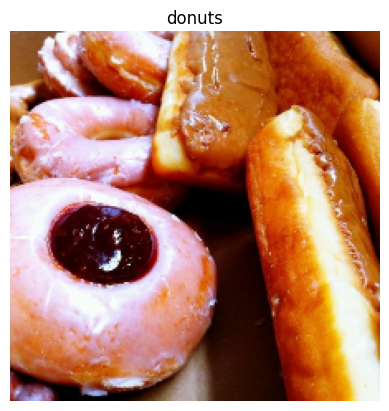

In [48]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & Prepare datasets

>Make the data input pipeline run really fast

link: https://www.tensorflow.org/guide/data_performance

In [49]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)


In [50]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

* `tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from helper_functions.py as create_tensorboard_callback())
* `tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
** Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [52]:
# Create TensorBoard callback (helper function)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requeres ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       monitor="val_accuracy",
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       verbose=0)

## Setup Mixed precision training

>Mixed precision training involves mixing float16 and float32 tensors to make better use of GPU's memory
>Using mixed precision training can improve performance on modern GPU's
>Link: https://www.tensorflow.org/guide/mixed_precision

In [53]:
# First import the API and then use the `set_global_policy()` method
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set the global policy to mixed precision

In [ ]:
from tensorflow.keras import layers


# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freeze base model layers


# Create Functional Model
inputs = layers.Input(shape=input_shape, name="input_layer")
# **Note**: EfficientNetBX has rescaling built in
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy"), # use when labels are *not* one-hot encoding
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"]

In [ ]:
# Check out the model summary
model.summary()

## Checking layer dtype policies
>Iterating through model's layers and printing layer attributes such as `dtype` and `dtype_policy`

In [ ]:
# Check the dtype_policy attributes of layers in the model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

* `layer.name (str)` : a layer's human-readable name, can be defined by the name parameter on construction
* `layer.trainable (bool)` : whether or not a layer is trainable all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy`: the data type a layer computes in

## Fit the feature extraction model

>To save time per epoch, only use 15% OF The test data

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevelt("ERROR")

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data)
                                                     validation_data=test_data,
                                                     validation_step=int(0.15 *len(test_data)),
                                                     callbacks=[create_tensorbord_callback("training_logs",
                                                                                           )]),


In [ ]:
# Evaluate it on the whole test data set
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

## Load and evaluate checkpoint weights

In [ ]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  # Create Functional Model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = base_model(inputs, training=False) # inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.AdamO(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

## Save Model to File


In [ ]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
# model.save(save_dir)

## Early Stopping


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

>**NOTE**: `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

>So as training goes on and our model gets closer and closer to it's ideal performance (also called convergence),

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no imp

## View training results on TensorBoard

link: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/#scalars

In [ ]:
# Upload experiment results to TensorBoard (uncomment to run)
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
#   --one_shot